<a href="https://colab.research.google.com/github/Moniga-17/AI-intern-assg/blob/main/AI_assg_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_path= "/content/sentimental.txt"
#train_data = pd.read_csv(train_path, sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python", encoding='latin1')

train_data = pd.read_csv(train_path, sep=":::", names=["TITLE", "REVIEWS", "RATING"], engine="python")

In [ ]:
train_data

,TITLE,REVIEWS,RATING
1,"Fullmetal Alchemist, Vol. 1",It masterfully weaves dark fantasy and emoti...,4.5
2,"Death Note, Vol, 1: Boredom",Its riveting storyline and complex character...,4.8
3,"Naruto, Vol. 1: Uzumaki Naruto","A great blend of action, humor, and heart mak...",4.7
4,"One Piece, Volume 1: Romance Dawn",One Piece Vol. 1: Romance Dawn brilliantly ki...,4.9
5,"Bleach, Vol. 1",It skillfully blends adventure and supernatur...,4.5
6,Solo Leveling,Its thrilling action and gripping story make...,4.7
7,Sweet Home,Its intense blend of horror and action keeps ...,4.6
8,The Horizon,Its powerful storytelling and impactful theme...,4.6
9,Noblesse,"Its blend of fantasy, action, and compelling...",4.5
10,Wind Breaker,"Its exciting blend of action, drama, and spor...",4.6


In [ ]:
permanent = train_data[['REVIEWS' , 'RATING']]
print(permanent.isnull().sum()) #Checking for null values
permanent.head()

REVIEWS    0
RATING     0
dtype: int64


,REVIEWS,RATING
1,It masterfully weaves dark fantasy and emoti...,4.5
2,Its riveting storyline and complex character...,4.8
3,"A great blend of action, humor, and heart mak...",4.7
4,One Piece Vol. 1: Romance Dawn brilliantly ki...,4.9
5,It skillfully blends adventure and supernatur...,4.5


In [ ]:
check =  permanent[permanent["RATING"].isnull()]
check.head()

,REVIEWS,RATING


In [ ]:
senti= permanent[permanent["RATING"].notnull()]
permanent.head()

,REVIEWS,RATING
1,It masterfully weaves dark fantasy and emoti...,4.5
2,Its riveting storyline and complex character...,4.8
3,"A great blend of action, humor, and heart mak...",4.7
4,One Piece Vol. 1: Romance Dawn brilliantly ki...,4.9
5,It skillfully blends adventure and supernatur...,4.5


In [ ]:
senti["senti"] = senti["RATING"]>=4.6
senti["senti"] = senti["senti"].replace([True , False] , ["pos" , "neg"])

<Axes: xlabel='senti'>

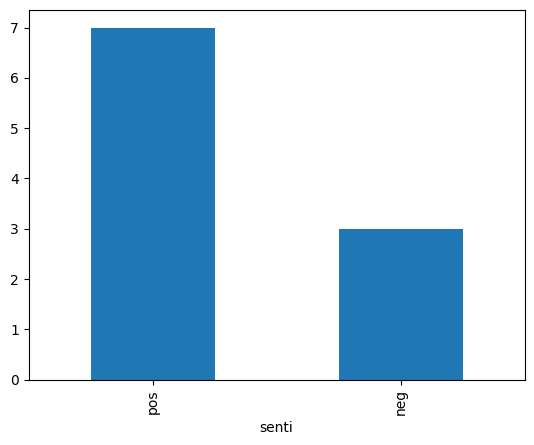

In [ ]:
senti["senti"].value_counts().plot.bar()

In [ ]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

senti["Summary_Clean"] = senti["REVIEWS"].apply(cleanup)
check["Summary_Clean"] = check["REVIEWS"].apply(cleanup)

In [ ]:
split = senti[["Summary_Clean" , "senti"]]
train=split.sample(frac=0.8,random_state=200)
test=split.drop(train.index)

In [ ]:
def word_feats(words):
    features = {}
    for word in words:
        features [word] = True
    return features

In [ ]:
train["words"] = train["Summary_Clean"].str.lower().str.split()
test["words"] = test["Summary_Clean"].str.lower().str.split()
check["words"] = check["Summary_Clean"].str.lower().str.split()

train.index = range(train.shape[0])
test.index = range(test.shape[0])
check.index = range(check.shape[0])
prediction =  {} ## For storing results of different classifiers

train_naive = []
test_naive = []
check_naive = []

for i in range(train.shape[0]):
    train_naive = train_naive +[[word_feats(train["words"][i]) , train["senti"][i]]]
for i in range(test.shape[0]):
    test_naive = test_naive +[[word_feats(test["words"][i]) , test["senti"][i]]]
for i in range(check.shape[0]):
    check_naive = check_naive +[word_feats(check["words"][i])]


classifier = NaiveBayesClassifier.train(train_naive)
print("NLTK Naive bayes Accuracy : {}".format(nltk.classify.util.accuracy(classifier , test_naive)))
classifier.show_most_informative_features(5)

NLTK Naive bayes Accuracy : 0.5
Most Informative Features
               adventure = True              neg : pos    =      2.3 : 1.0
                      an = True              neg : pos    =      2.3 : 1.0
              characters = True              neg : pos    =      2.3 : 1.0
                standout = True              neg : pos    =      2.3 : 1.0
                      to = None              neg : pos    =      2.3 : 1.0


In [ ]:
y =[]
only_words= [test_naive[i][0] for i in range(test.shape[0])]
for i in range(test.shape[0]):
    y = y + [classifier.classify(only_words[i] )]
prediction["Naive"]= np.asarray(y)

y1 = []
for i in range(check.shape[0]):
    y1 = y1 + [classifier.classify(check_naive[i] )]

check["Naive"] = y1

In [ ]:
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

stopwords = set(STOPWORDS)
stopwords.remove("not")

# Convert the stopwords set to a list
stopwords = list(stopwords)

count_vect = CountVectorizer(min_df=2, stop_words=stopwords, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()

# Check if the dataframe is empty before transforming
if not train["Summary_Clean"].empty:
    X_train_counts = count_vect.fit_transform(train["Summary_Clean"])
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

if not test["Summary_Clean"].empty:
    X_new_counts = count_vect.transform(test["Summary_Clean"])
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)

if not check["Summary_Clean"].empty:
    checkcounts = count_vect.transform(check["Summary_Clean"])
    checktfidf = tfidf_transformer.transform(checkcounts)
else:
    print("The 'check' dataframe is empty.")


The 'check' dataframe is empty.


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [ ]:
!pip install wordcloud
!pip install scikit-learn


In [ ]:
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
stopwords = set(STOPWORDS)
stopwords.remove("not")


In [ ]:
count_vect = CountVectorizer(min_df=2, stop_words=stopwords, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer()


In [ ]:
count_vect = CountVectorizer(min_df=2, stop_words=list(stopwords), ngram_range=(1, 2)) # Convert stopwords to a list
tfidf_transformer = TfidfTransformer()

In [ ]:
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [ ]:
# Check if 'check' DataFrame is empty
if check.empty:
    print("Error: 'check' DataFrame is empty. Please provide data for transformation.")
else:
    # Check if 'Summary_Clean' column contains only empty strings
    if all(check["Summary_Clean"].apply(lambda x: str(x).strip() == "")):
        print("Error: 'Summary_Clean' column contains only empty strings.")
    else:
        checkcounts = count_vect.transform(check["Summary_Clean"])
        checktfidf = tfidf_transformer.transform(checkcounts)

Error: 'check' DataFrame is empty. Please provide data for transformation.


In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='lbfgs' , C=1000)

# Ensure 'senti' column in train and test DataFrames have the same data type
# Assuming your model is trained on 'pos' and 'neg' labels, convert
# booleans to strings in the test DataFrame:
test["senti"] = test["senti"].map({True: 'pos', False: 'neg'})

# Fit the model:
logistic = logreg.fit(X_train_tfidf, train["senti"])

# Predict probabilities:
prediction['LogisticRegression'] = logreg.predict_proba(X_test_tfidf)[:,1]

# Calculate and print the accuracy score:
print("Logistic Regression Accuracy : {}".format(logreg.score(X_test_tfidf , test["senti"])))

# If check is not empty and Summary_Clean column is not empty, then predict
if not check.empty and not all(check["Summary_Clean"].apply(lambda x: str(x).strip() == "")):
    check["log"] = logreg.predict(checktfidf) # Predicting Sentiment for Check

Logistic Regression Accuracy : 0.5


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'count_vect' is your CountVectorizer instance
words = count_vect.get_feature_names_out() # Use get_feature_names_out() instead of get_feature_names()
feature_coefs = pd.DataFrame(
    data=list(zip(words, logistic.coef_[0])),
    columns=['feature', 'coef']
)
feature_coefs.sort_values(by="coef")

,feature,coef
1,adventure,-6.764579
11,standout,-6.010205
5,make,-4.344986
2,blend,-3.614145
3,characters,-2.370400
10,series,-0.555878
0,action,2.429518
6,make must,2.701197
7,must,2.701197
8,must read,2.701197


In [ ]:
test.senti = test.senti.replace(["pos" , "neg"] , [True , False] )

<ipython-input-70-f309f0886635>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.senti = test.senti.replace(["pos" , "neg"] , [True , False] )


In [ ]:
from sklearn import metrics  # Import the metrics module from sklearn

keys = prediction.keys()
for key in ['Multinomial', 'LogisticRegression']:
    print(" {}:".format(key))
    print(metrics.classification_report(test["senti"], prediction.get(key)>.5, target_names = ["positive", "negative"]))
    print("\n")

 Multinomial:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
    negative       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



 LogisticRegression:
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
    negative       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "One Piece Vol. 1: Romance Dawn brilliantly kicks off the legendary adventure of Luffy and his quest to become the Pirate King. It's action-packed and filled with heart.")
test_sample(logreg, "Its blend of fantasy, action, and compelling characters make it a standout series")


Sample estimated as POS: negative prob 0.010501, positive prob 0.989499
Sample estimated as NEG: negative prob 0.983321, positive prob 0.016679


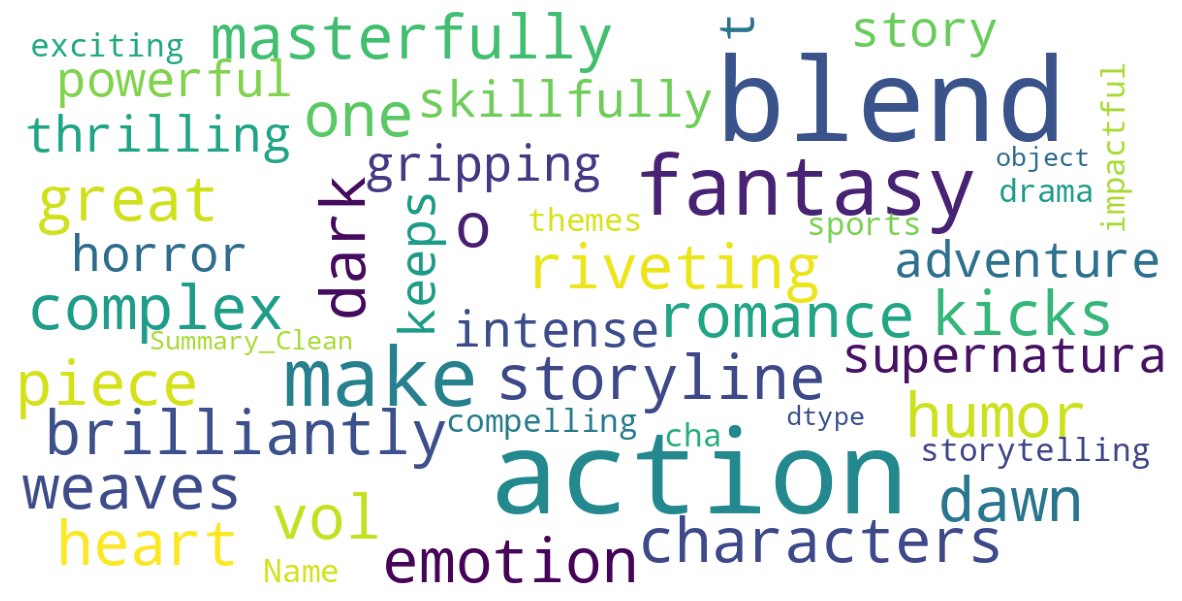

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl # Import the matplotlib library and assign it to the alias 'mpl'
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


mpl.rcParams['font.size']=12                #10
mpl.rcParams['savefig.dpi']=100             #72
mpl.rcParams['figure.subplot.bottom']=.1


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads

    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(senti["Summary_Clean"])

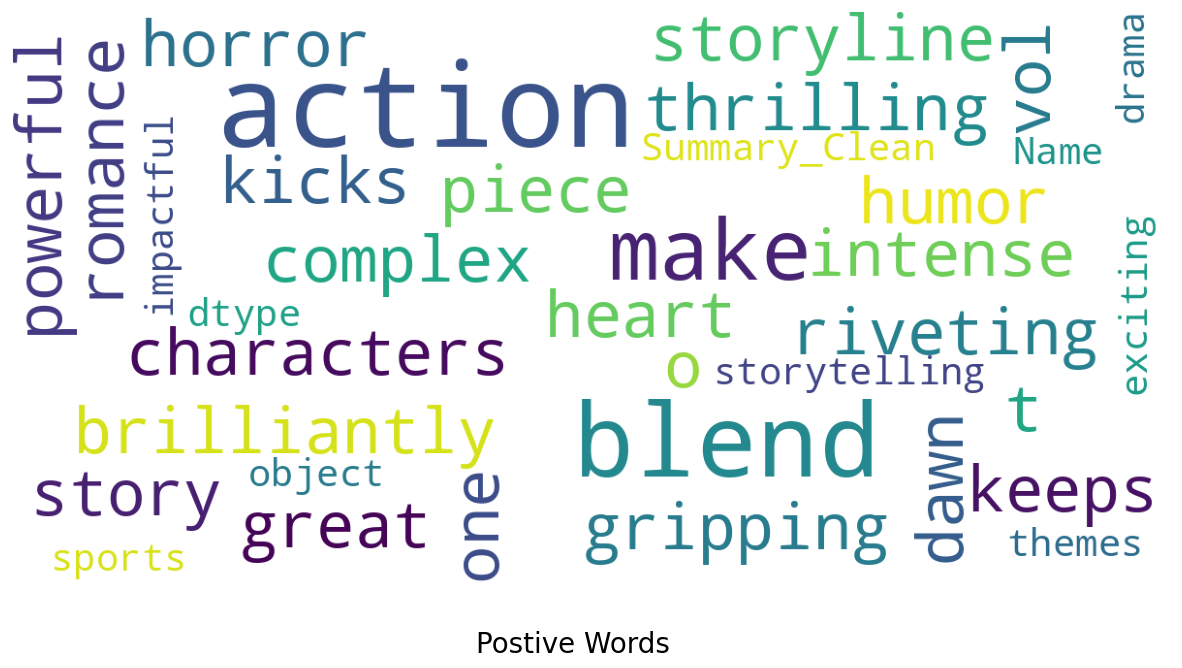

In [ ]:
show_wordcloud(senti["Summary_Clean"][senti.senti == "pos"] , title="Postive Words")

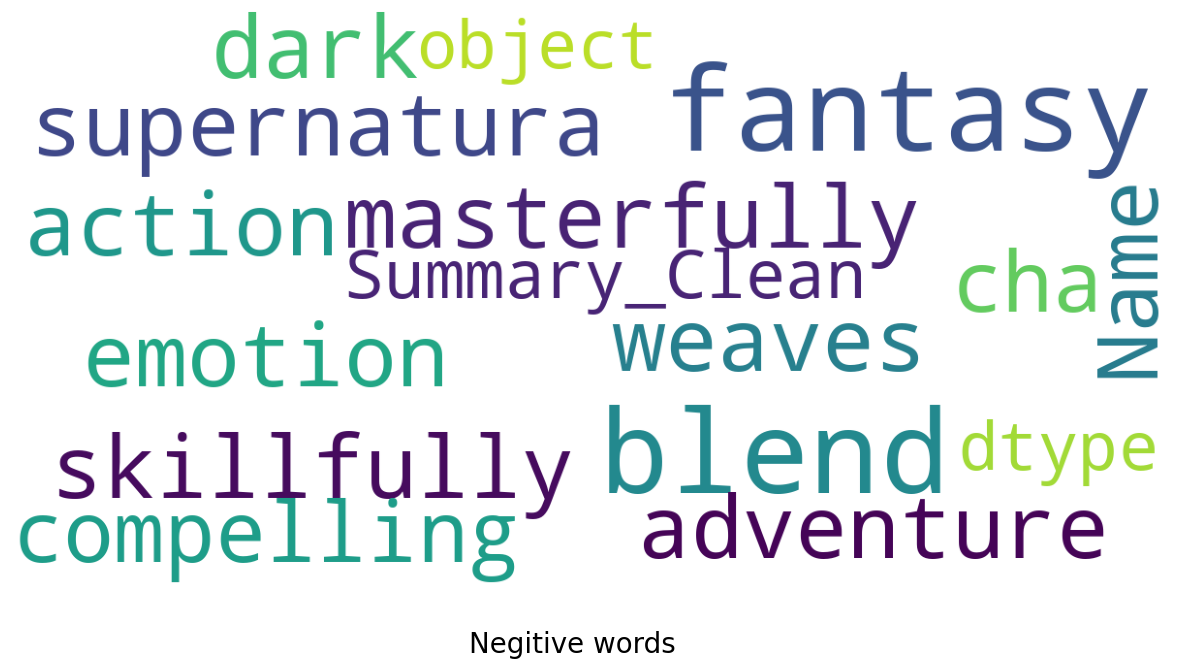

In [ ]:
show_wordcloud(senti["Summary_Clean"][senti.senti == "neg"] , title="Negitive words")

In [ ]:
def wcloud(data,var, path,label):
    mask = np.array(Image.open(path))
    text_mt = " ".join(t for t in data[var])
    wordcloud_usa = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000, mask=mask).generate(text_mt)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
    plt.title(label)
    plt.axis("off")

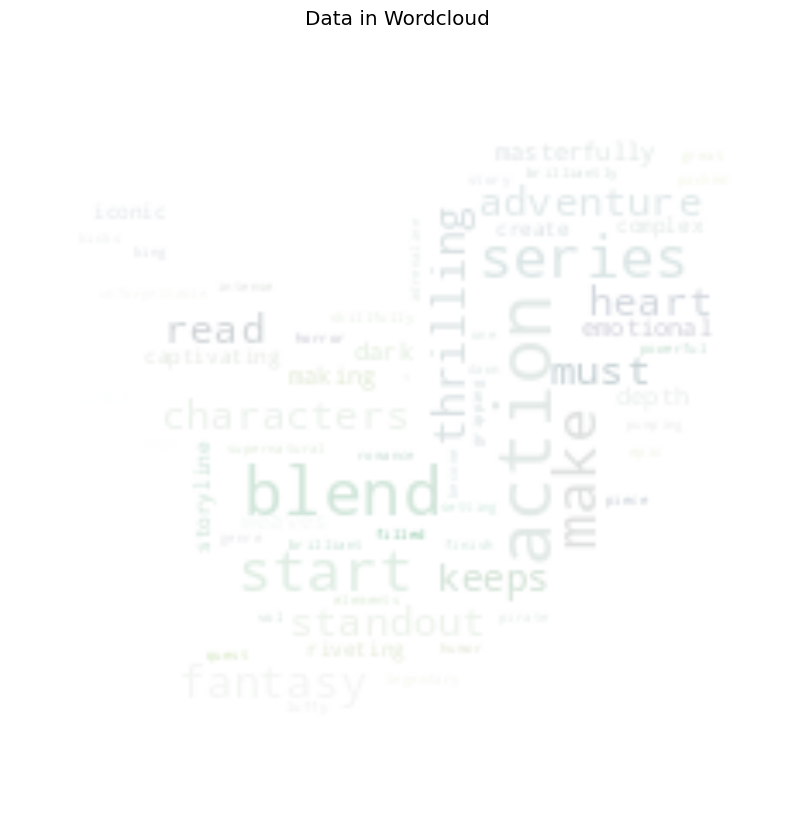

In [ ]:
# Import necessary libraries
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Assuming 'senti' is your DataFrame
# and "Summary_Clean" the column with text data

# Replace with your actual data loading and preprocessing if needed
# val = senti[senti["toxicity"] > some_threshold]  # Example: Filtering for 'toxic' entries
val = senti  # Your data here

def wcloud(data, var, path, label):  # Fixed function signature
    mask = np.array(Image.open(path))
    text_mt = " ".join(t for t in data[var])
    wordcloud_usa = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000, mask=mask).generate(text_mt)

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
    plt.title(label)
    plt.axis("off")
    plt.show()  # Added to display the plot

# Assuming "Summary_Clean" is the column you want to use
wcloud(val, "Summary_Clean", "/content/wordcloud.jpeg", "Data in Wordcloud")

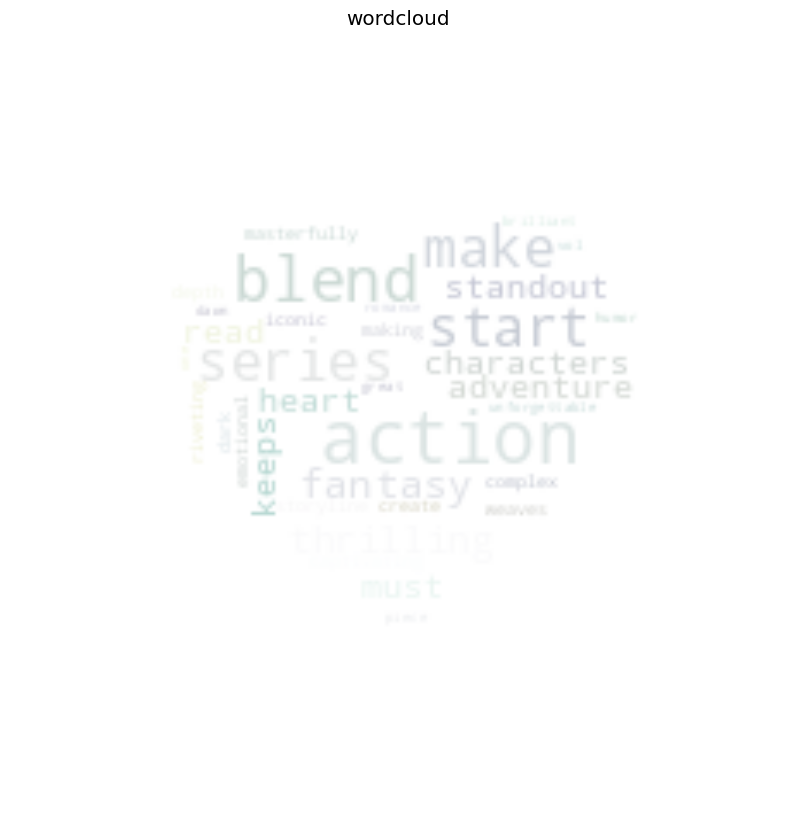

In [ ]:
wcloud(val,"Summary_Clean","/content/wordcloud2.jpeg","wordcloud")